In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 200)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split, RandomizedSearchCV


from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate , cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Identifies and categorizes the columns in a DataFrame into categorical, numerical, 
    high-cardinality categorical, and numerical-but-categorical columns.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The input DataFrame from which the columns will be categorized.
    
    cat_th : int, optional (default=10)
        The threshold for the maximum number of unique values a numerical column can have 
        to be considered categorical (`num_but_cat`).
    
    car_th : int, optional (default=20)
        The threshold for the minimum number of unique values a categorical column can have 
        to be considered high-cardinality (`cat_but_car`).

    Returns:
    -------
    cat_cols : list
        A list of columns categorized as categorical (includes both object types and numerical 
        columns with fewer unique values than `cat_th`).

    num_cols : list
        A list of columns categorized as numerical (excluding those with fewer unique values 
        than `cat_th`).

    cat_but_car : list
        A list of columns that are categorical but have high cardinality (more than `car_th` 
        unique values).

    Prints:
    -------
    - The number of observations (rows) and variables (columns) in the DataFrame.
    - The number of categorical columns, numerical columns, high-cardinality categorical columns, 
      and numerical-but-categorical columns.

    Notes:
    ------
    - The function categorizes columns into three groups: categorical, numerical, and high-cardinality categorical.
    - Numerical columns with fewer unique values than `cat_th` are considered categorical (`num_but_cat`).
    - Categorical columns with more unique values than `car_th` are considered high-cardinality (`cat_but_car`).
    """

    # Identify categorical columns (object, category, bool types)
    cat_cols = [col for col in dataframe.columns 
                if dataframe[col].dtypes in ['object', 'category', 'bool']]

    # Identify numerical columns that should be treated as categorical based on the unique value threshold
    num_but_cat = [col for col in dataframe.columns 
                   if dataframe[col].nunique() < cat_th 
                   and dataframe[col].dtypes in ["int64", "float64"]]

    # Identify high-cardinality categorical columns
    cat_but_car = [col for col in dataframe.columns 
                   if dataframe[col].nunique() > car_th 
                   and str(dataframe[col].dtypes) in ["category", "object"]]

    # Combine categorical columns and numerical-but-categorical columns, exclude high-cardinality
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Identify true numerical columns (excluding those that are treated as categorical)
    num_cols = [col for col in dataframe.columns 
                if dataframe[col].dtypes in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    # Print dataset information and column classifications
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


In [3]:
def encode_and_split_data(df, target_col, cat_cols, cat_but_car, num_cols, test_size=0.2, random_state=42):
    """
    Splits the dataset into train and test sets, applies target encoding and one-hot encoding 
    to categorical columns, and returns the encoded data along with the target variables.

    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame containing both features and the target column.

    target_col : str
        The name of the target column that will be predicted.

    cat_cols : list
        A list of categorical columns with low cardinality (for one-hot encoding).

    cat_but_car : list
        A list of categorical columns with high cardinality (for target encoding).

    num_cols : list
        A list of numerical columns to be used as is.

    test_size : float, optional (default=0.2)
        The proportion of the dataset to include in the test split.

    random_state : int, optional (default=42)
        Random seed to ensure reproducibility of the train-test split.

    Returns:
    -------
    X_train_final : pd.DataFrame
        Encoded and concatenated training features, including both categorical and numerical columns.

    X_test_final : pd.DataFrame
        Encoded and concatenated testing features, including both categorical and numerical columns.

    y_train : pd.Series
        The target values for the training set.

    y_test : pd.Series
        The target values for the test set.

    Raises:
    ------
    KeyError
        If the target column is not found in the DataFrame.

    Notes:
    ------
    - The function performs target encoding on high-cardinality categorical columns.
    - It performs one-hot encoding on low-cardinality categorical columns.
    - Resets the indices of the resulting DataFrames to avoid misalignment issues.
    """

    # Ensure the target column exists
    if target_col not in df.columns:
        raise KeyError(f"'{target_col}' not found in the DataFrame columns")

    # Step 1: Split into features (X) and target (y)
    X = df.drop(target_col, axis=1)
    print("X columns: ", X.columns)
    y = df[target_col]

    # Exclude the target column from the numerical columns list
    num_cols_filtered = [col for col in num_cols if col != target_col]

    # Step 2: Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Step 3: Apply Target Encoding to high-cardinality categorical columns
    encoder = ce.TargetEncoder(cols=cat_but_car)
    X_train_encoded = encoder.fit_transform(X_train[cat_but_car], y_train)
    X_test_encoded = encoder.transform(X_test[cat_but_car])

    # Step 4: Apply One-Hot Encoding to low-cardinality categorical columns
    ohe = OneHotEncoder(drop="first", sparse=False)  # Perform One-Hot Encoding
    X_train_encoded_ohe = ohe.fit_transform(X_train[cat_cols])
    X_test_encoded_ohe = ohe.transform(X_test[cat_cols])

    # Convert OHE arrays to DataFrames with column names
    ohe_columns = ohe.get_feature_names_out(cat_cols)
    X_train_encoded_ohe_df = pd.DataFrame(X_train_encoded_ohe, columns=ohe_columns)
    X_test_encoded_ohe_df = pd.DataFrame(X_test_encoded_ohe, columns=ohe_columns)

    # Reset the indices to avoid any misalignment during concatenation
    X_train_encoded.reset_index(drop=True, inplace=True)
    X_test_encoded.reset_index(drop=True, inplace=True)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    X_train_encoded_ohe_df.reset_index(drop=True, inplace=True)
    X_test_encoded_ohe_df.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    # Step 5: Concatenate encoded features with numerical columns
    X_train_final = pd.concat(
        [X_train_encoded, X_train_encoded_ohe_df, X_train[num_cols_filtered]], axis=1
    )
    X_test_final = pd.concat(
        [X_test_encoded, X_test_encoded_ohe_df, X_test[num_cols_filtered]], axis=1
    )

    return X_train_final, X_test_final, y_train, y_test


In [4]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)  # Modelin tahminlerini al  
    errors = abs(predictions - test_labels)  # Hata hesapla
    mape = 100 * np.mean(errors / test_labels)  # MAPE (Ortalama Mutlak Yüzde Hata) hesapla
    accuracy = 100 - mape # Doğruluk hesapla
    
    r2 = r2_score(y_test, predictions)  # R² skoru hesapla
    mse = mean_squared_error(test_labels, predictions)  # MSE (Ortalama Kare Hata) hesapla
    mae = mean_absolute_error(test_labels, predictions)   # MAE (Ortalama Mutlak Hata) hesapla
    
    
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R² Score: {r2}")
    return accuracy

In [5]:
Flights = pd.read_csv("/kaggle/input/flights-after-eda/Flights.csv")
df = Flights.copy()
df.head(2)

,Unnamed: 0,Year,quarter,city1,city2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,dep_city,dep_state,dest_city,dest_state,fare_per_mile
0,0,2021,3,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",ABE,PIE,970,180,81.43,G4,1.0000,81.43,G4,1.0000,81.43,Allentown/Bethlehem/Easton,PA,Tampa,FL (Metropolitan Area),0.083948
1,1,2021,3,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",ABE,TPA,970,19,208.93,DL,0.4659,219.98,UA,0.1193,154.11,Allentown/Bethlehem/Easton,PA,Tampa,FL (Metropolitan Area),0.215392


In [6]:
df.drop(columns=["Unnamed: 0","city1","city2","fare_low",'fare_lg',"fare_per_mile"] , axis = 1 , inplace=True) 
# # gereksizler ayrıca fare_lg , fare_low ,  fare_per_mile sütunları da silinmeli modele geçmeden önce.

In [7]:
df.head()

,Year,quarter,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,carrier_low,lf_ms,dep_city,dep_state,dest_city,dest_state
0,2021,3,ABE,PIE,970,180,81.43,G4,1.0000,G4,1.0000,Allentown/Bethlehem/Easton,PA,Tampa,FL (Metropolitan Area)
1,2021,3,ABE,TPA,970,19,208.93,DL,0.4659,UA,0.1193,Allentown/Bethlehem/Easton,PA,Tampa,FL (Metropolitan Area)
2,2021,3,ABQ,DAL,580,204,184.56,WN,0.9968,WN,0.9968,Albuquerque,NM,Dallas/Fort Worth,TX
3,2021,3,ABQ,DFW,580,264,182.64,AA,0.9774,AA,0.9774,Albuquerque,NM,Dallas/Fort Worth,TX
4,2021,3,ABQ,PHX,328,398,177.11,WN,0.6061,AA,0.3939,Albuquerque,NM,Phoenix,AZ


In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df , cat_th= 5 ,car_th=20 )
print("**"*10)
print("Categorical Columns:", cat_cols)
print("--"*20)
print("Numerical Columns:", num_cols)
print("--"*55)
print("Categorical But High Cardinality Columns:", cat_but_car)

Observations: 230745
Variables: 15
cat_cols: 1
num_cols: 6
cat_but_car: 8
num_but_cat: 1
********************
Categorical Columns: ['quarter']
----------------------------------------
Numerical Columns: ['Year', 'nsmiles', 'passengers', 'fare', 'large_ms', 'lf_ms']
--------------------------------------------------------------------------------------------------------------
Categorical But High Cardinality Columns: ['airport_1', 'airport_2', 'carrier_lg', 'carrier_low', 'dep_city', 'dep_state', 'dest_city', 'dest_state']


In [9]:
df.describe()

,Year,quarter,nsmiles,passengers,fare,large_ms,lf_ms
count,230745.000000,230745.000000,230745.000000,230745.000000,230745.000000,230745.000000,230745.000000
mean,2008.516445,2.481094,1198.906585,250.585998,213.998637,0.663867,0.446963
std,8.693293,1.122892,691.661434,345.071133,69.665023,0.223402,0.331128
min,1993.000000,1.000000,122.000000,0.000000,50.000000,0.100000,0.010000
25%,2001.000000,1.000000,643.000000,23.000000,164.230000,0.480000,0.150000
50%,2008.000000,2.000000,1028.000000,113.000000,207.990000,0.650400,0.360000
75%,2016.000000,3.000000,1733.000000,322.000000,259.340000,0.870000,0.743400
max,2024.000000,4.000000,2724.000000,1838.000000,457.000000,1.000000,1.000000


<Axes: >

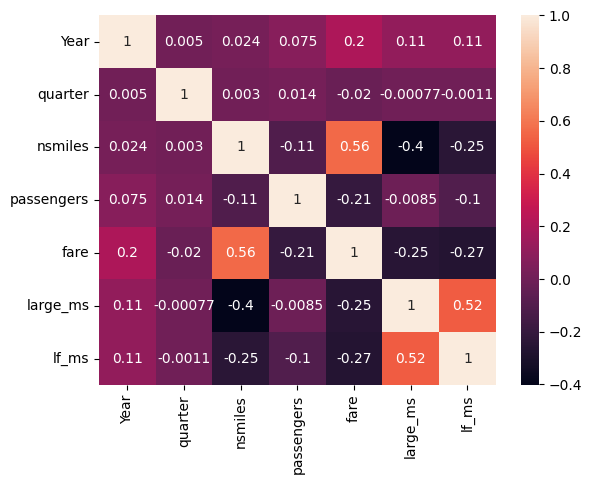

In [10]:
sns.heatmap(data = df.corr(numeric_only=True) ,annot = True )

Split the dataset into train and test, Encoding and Reset indexes.

In [11]:
X_train_final, X_test_final, y_train, y_test = encode_and_split_data(df=df,
                                                                        target_col='fare',
                                                                        cat_cols=cat_cols,
                                                                        cat_but_car=cat_but_car,
                                                                        num_cols=num_cols,
                                                                        test_size=0.2,
                                                                        random_state=42)

X columns:  Index(['Year', 'quarter', 'airport_1', 'airport_2', 'nsmiles', 'passengers',
       'carrier_lg', 'large_ms', 'carrier_low', 'lf_ms', 'dep_city',
       'dep_state', 'dest_city', 'dest_state'],
      dtype='object')


In [12]:
X_train_final.head(2)

,airport_1,airport_2,carrier_lg,carrier_low,dep_city,dep_state,dest_city,dest_state,quarter_2,quarter_3,quarter_4,Year,nsmiles,passengers,large_ms,lf_ms
0,217.040655,117.834017,115.972580,132.693529,217.040655,211.858268,204.467312,207.715333,0.0,1.0,0.0,2023,1225,189,1.00,1.00
1,204.437075,204.843620,228.993946,215.914340,204.437075,203.948472,226.001880,226.001880,0.0,0.0,0.0,2006,700,35,0.87,0.05


In [13]:
X_test_final.head(2)

,airport_1,airport_2,carrier_lg,carrier_low,dep_city,dep_state,dest_city,dest_state,quarter_2,quarter_3,quarter_4,Year,nsmiles,passengers,large_ms,lf_ms
0,217.677498,181.118418,195.886608,225.159703,217.677498,223.262506,172.511776,182.348099,1.0,0.0,0.0,2011,460,212,0.8100,0.1300
1,239.129723,253.014917,228.993946,234.128035,239.129723,225.405087,226.001880,226.001880,0.0,0.0,0.0,2019,1002,10,0.6277,0.3404


Scaling should be done after Encoding.

At this stage I can't decide which Scaling method to use so I will try to compare them all.

* Note : It doesn't matter ,so I deleted the other alternatives.

In [14]:
# Scaling objects

std_scaler = StandardScaler() # Normal dağılıma sahip veriler için. For Normal distributed features

# dağılıma bakmak için görselleştiriyorum.

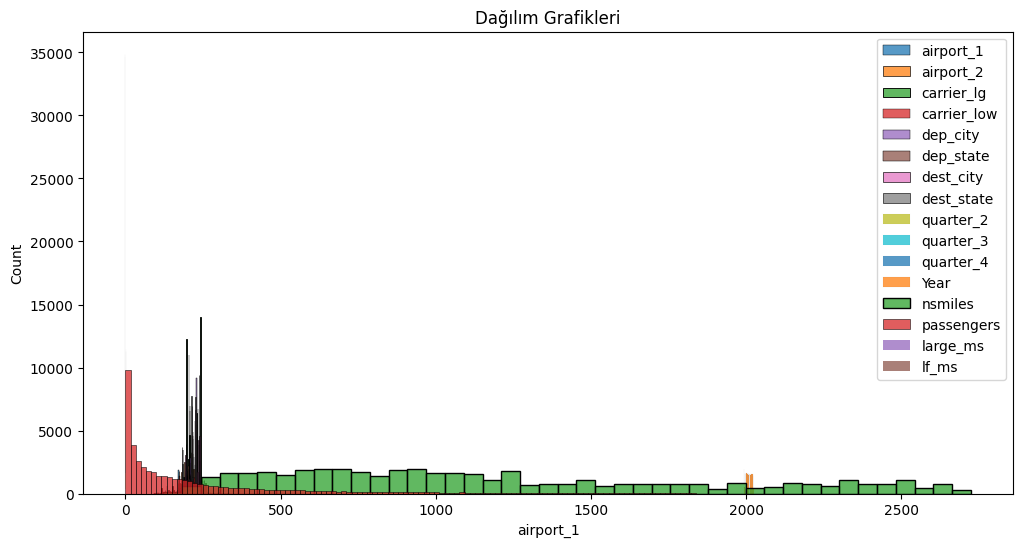

In [15]:
# The columns I want to see the distribution.
columns_to_plot = X_train_final.columns


plt.figure(figsize=(12, 6))


for col in columns_to_plot:
    sns.histplot(data=X_test_final[col], label=col, fill=True)


plt.title("Dağılım Grafikleri")
plt.legend()

plt.show()

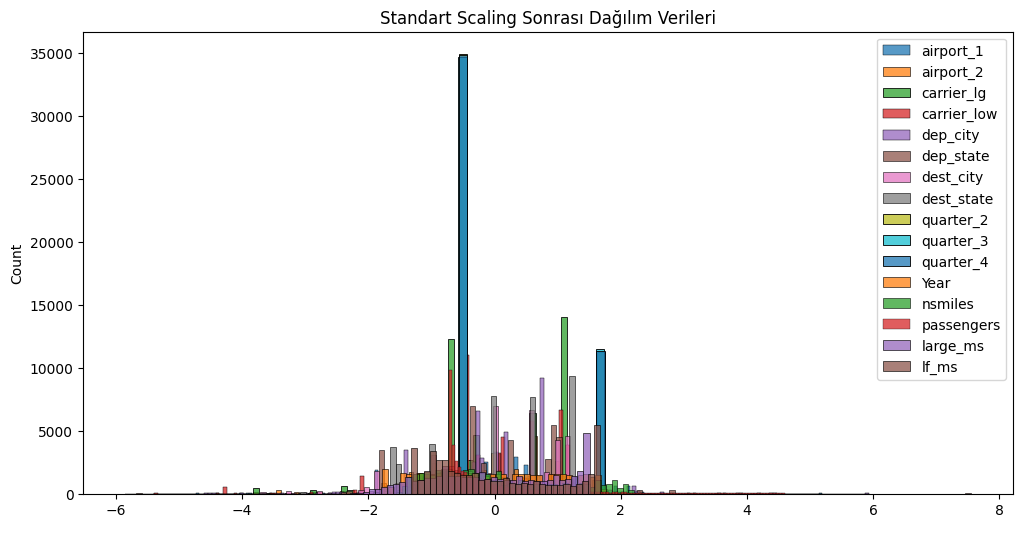

In [16]:
## if I use Standart Scaling.

X_train_standart = std_scaler.fit_transform(X_train_final)
X_test_standart = std_scaler.transform(X_test_final)


df_1 = pd.DataFrame(X_train_standart , columns=X_train_final.columns)
df_2 = pd.DataFrame(X_test_standart, columns=X_test_final.columns)

# Visualization: 

# columns_to_plot = X_train_final.columns #test ve train column aynı sonucu veriyor.


plt.figure(figsize=(12, 6))


for col in columns_to_plot:
    sns.histplot(data=df_2[col], label=col, fill=True)


plt.title("Standart Scaling Sonrası Dağılım Verileri")
plt.legend()
plt.xlabel(" ")
plt.show()

scaling den sonra denemeler yaptığım için işimi kolaylaştırıyorum. aşağıda Modele vereceğim son veriler olacak.

In [17]:
# scale 
X_train = X_train_standart
X_test = X_test_standart

**X_train ve X_test np.array nesnesi. eğer df olarak kullanmak istersen df_1 ve df_2 olarak ulaşabilirsin. İçerikleri aynı.**

X_train_final, X_test_final sonradan kullanılacak , encode edilmiş ancak scale edilmemiş df.

## **Model Creation**
Bu kısımda tüm regresyon algoritmalarını denedim ancak aralarında en iyi sonucu RandomForestRegressor() verdi. Bu yüzden onunla devam ediyorum , kalanları sildim.

In [18]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(X_train, y_train)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Evaluating the model

accuracy = evaluate(regressor, X_test, y_test)

Out-of-Bag Score: 0.6822467879904781
Model Performance
Average Error: 19.3221 degrees.
Accuracy = 90.63%.
Mean Squared Error: 815.8209042699084
Mean Absolute Error: 19.32206947062775
R² Score: 0.8313453920455188


# HİPERPARAMETRE OPTİMİZASYONU

In [19]:
# Başta 30k kayıt aldığım için bu kısmı çıkarıyorum. En son tekrar çalışacak.

# df_1'den rastgele 10k kayıt çekiyorum. Kısa sürmesi için.
X_subset = df_1.sample(n=10000, random_state=42)  # df_1  , X_train in df hali. birebir aynı. 


y_subset = y_train.loc[X_subset.index] # X_subset ile eşleşen kayıtları alıyor
y_subset = y_subset.values.ravel()  # uyarı aldığımdan dolayı array haline çeviriyorum. Model için uygun olan buymuş.

In [20]:
n_estimators = [100, 200, 400, 600, 800, 1000, 1200]

# Number of features to consider at every split
max_features = ["log2", 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 400, 600, 800, 1000, 1200], 'max_features': ['log2', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [21]:
# create base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 50,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)


# Fit the random search model on the subset. # Bu kısım son çalıştırmada değişecek !
rf_random.fit(X_subset, y_subset)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  19.2s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  21.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  20.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  25.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=  23.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   7.4s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800, 1000, 1200]},
                   random_state=42, verbose=2)

In [22]:
# Özellik Önem Analizi

best_rf = rf_random.best_estimator_
feature_importance = best_rf.feature_importances_

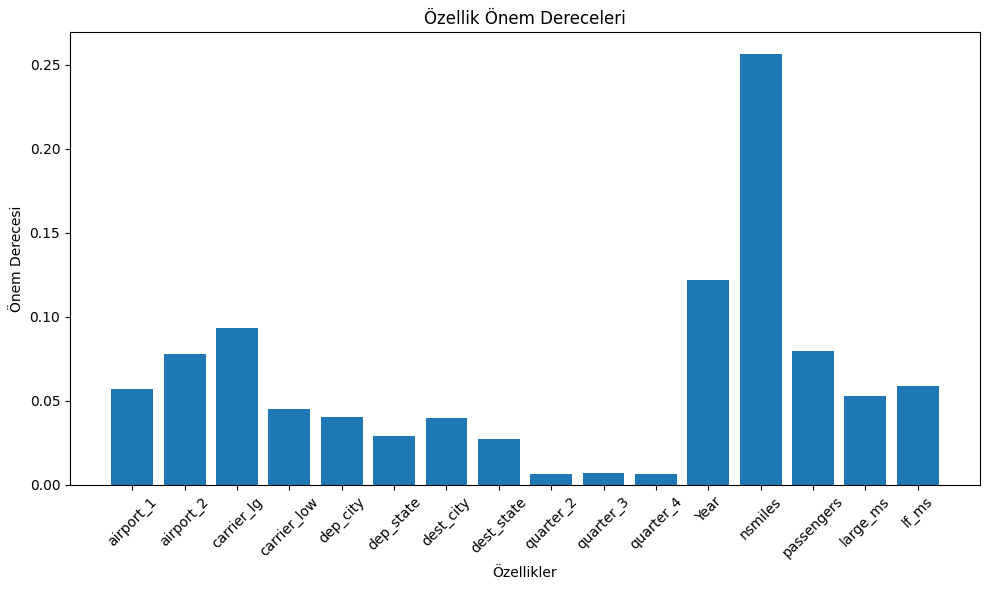

In [23]:
plt.figure(figsize = (10,6))
plt.bar(df_1.columns, feature_importance)
plt.title('Özellik Önem Dereceleri')
plt.xlabel('Özellikler')
plt.ylabel('Önem Derecesi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
best_rf.fit(X_train , y_train) # best_rf modelini tüm eğitim verisiyle eğitiyorum.

[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  19.3s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  21.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  20.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  25.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  10.6s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   7.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   7.4s
[CV] END bootstrap=True, max_depth=60, max

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='log2',
                      n_estimators=1200)

best_rf modelini eğittikten sonra tahmin yaptırıyorum. Ardından Modeli değerlendirmek için en başta tanımladığım evaluate fonksiyonunu kullanıyorum.

In [25]:
y_pred = best_rf.predict(X_test)

final_accuracy = evaluate(best_rf, X_test, y_test)

Model Performance
Average Error: 18.5220 degrees.
Accuracy = 91.00%.
Mean Squared Error: 755.4095027366814
Mean Absolute Error: 18.522000200718868
R² Score: 0.843834237560804


R^2 score increased after hyperparameter optimization, so we didn't wait in vain :)

In [26]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [27]:
X_full = pd.DataFrame(np.concatenate([X_train, X_test], axis=0))
X_full.columns = df_1.columns  # df ihtiyacı olursa bunu kullan.

# Dikey birleştirme (vstack)
X_combined_v = np.vstack((X_train, X_test)) # KMeans array ister imiş. array ihtiyacı olursa bunu kullan.

In [28]:
y_full = pd.DataFrame(np.concatenate([y_train, y_test], axis=0))
y_full.columns = ["fare"]   # df ihtiyacı olursa bunu kullan.

# tek boyutlu olduklarından dolayı yatay yığınlandı.
y_combined = np.hstack((y_train,y_test))   # array ihtiyacı olursa bunu kullan

In [29]:
df_full = pd.concat([X_full, y_full], axis=1)

df_full.head(1) # column 16 is the target.

,airport_1,airport_2,carrier_lg,carrier_low,dep_city,dep_state,dest_city,dest_state,quarter_2,quarter_3,quarter_4,Year,nsmiles,passengers,large_ms,lf_ms,fare
0,0.136826,-3.796477,-3.801681,-4.285522,0.156832,-0.129084,-0.433886,-0.321304,-0.570736,1.736038,-0.571103,1.668573,0.039433,-0.178778,1.504223,1.669605,130.43


X_train_final, X_test_final, y_train, y_test hala scale edilmemiş halde.

In [30]:
X_train_test_full = pd.concat([X_train_final,X_test_final] , ignore_index= True)

X_train_test_full DataFrame i X_full Df inin scale edilmemiş hali. Küme sayısı belirlemek için kullanılacak. X_full df inin np.array karşılığı da X_combined_v . 

In [31]:
X_train_test_full.head(1) # hedef değişken bulunmuyor !

,airport_1,airport_2,carrier_lg,carrier_low,dep_city,dep_state,dest_city,dest_state,quarter_2,quarter_3,quarter_4,Year,nsmiles,passengers,large_ms,lf_ms
0,217.040655,117.834017,115.97258,132.693529,217.040655,211.858268,204.467312,207.715333,0.0,1.0,0.0,2023,1225,189,1.0,1.0


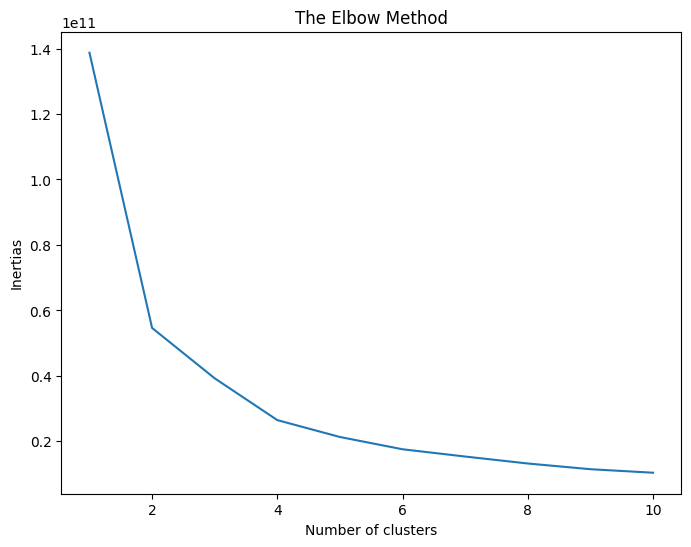

In [32]:
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300, n_init=12, random_state=0)
    kmeans.fit(X_train_test_full)
    inertias.append(kmeans.inertia_)
f3, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,11),inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show()

In [33]:
# 2. Improved PCA with automatic component selection based on explained variance. Manual olarak yapmıştım.
def run_pca(X_data, variance_threshold=0.95):
#     """
#     Bu fonksiyon, 
#     veriden belirli bir açıklanan varyans oranını yakalayacak kadar bileşen seçen geliştirilmiş bir PCA algoritması uygular.
#     """
    
    pca = PCA(n_components=None) # PCA nesnesi oluşturuluyor.
    X_pca = pca.fit_transform(X_data) # bu satır ile PCA uygulanır ve veriler dönüşür.
    
    explained_variance_ratio = pca.explained_variance_ratio_ # pca'nın her bileşeni tarafından açıklanan varyans oranını verir.
    cumulative_variance = np.cumsum(explained_variance_ratio) # yukarıdaki oranların kümülatif toplamını verir.
    

    num_components = np.argmax(cumulative_variance >= variance_threshold) + 1
# kümülatif varyansın threshold değerini aştığı ilk bileşenin indeksi yakalanır , +1 eklenerek bileşen sayısı belirlenir.
    print(f"Number of components selected: {num_components}")
    print(f"Explained variance with {num_components} components: {cumulative_variance[num_components - 1]}")
    
    # Re-run PCA with the selected number of components
    pca_final = PCA(n_components=num_components) # num_components kadar bileşen ile son pca nesnesi oluşturulur. 
    X_pca_final = pca_final.fit_transform(X_data) # Bu bileşen sayısıyla PCA tekrar uygulanır ve veri dönüşür.
    
    return X_pca_final, pca_final # dönüştürlmüş veri ve son pca nesnesini döndürüyor.


def run_kmeans_with_evaluation(X_data, n_clusters=4):
#     """ 
#     K-Means modelini belirli bir küme sayısıyla uygular,
#     küme etiketlerini tahmin eder ve Silhouette Score ve Davies-Bouldin Index ile performansı değerlendirir.
#     """

    # Step 1: Fit the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42) # n_clusters kadar küme ile kmeans nesnesi oluşturuluyor.
    kmeans.fit(X_data) #  kmeans modeli veriler üzerinde eğitilir.
    
    #  Predict clusters
    cluster_labels = kmeans.labels_ 
    # bu özellik her bir veri noktasının hangi kümeye ait olduğunu gösteren etiketleri içerir.
    # veriler hangi kğmede onu tuttuğu için tahmin diyorum.

    
    # Step 3: Evaluate using Silhouette Score and Davies-Bouldin Index
    silhouette_avg = silhouette_score(X_data, cluster_labels) 
    # Bu skor, kümeleme kalitesinin bir göstergesidir.0-1 arasındadır.
    
    db_score = davies_bouldin_score(X_data, cluster_labels)
    #  küme içindeki ayrılığı ve kümeler arasındaki ayrımı ölçer. 0-sonsuz araşılığında.
    
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")
    print(f"Davies-Bouldin Index for {n_clusters} clusters: {db_score}")
    
    return kmeans, cluster_labels # kmeans modelini ve veriler için tahmin edilen küme etiketlerini döndürür.
                                        

# 3. Visualize clusters in PCA-reduced space
def plot_clusters_pca(X_pca_data, labels, n_clusters):
#     """ 
#     Bu fonksiyon, PCA ile indirgenen veri uzayında kümeleri görselleştirir.
#     """

    plt.figure(figsize=(10, 7))
    
    # Scatter plot with clusters
    for cluster in range(n_clusters):
        cluster_points = X_pca_data[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")
        
#         Her bir küme için bir döngü oluşturulur.
#         sırası gelen kümenin tüm veri noktalarını seçer.
#         her bir kümenin veri noktaları iki boyutlu scatter plot üzerinde çizilir
#         Her küme, label parametresi ile etiketlenir.
    
# Grafik düzenlemesi.    
    plt.title(f"K-Means Clusters Visualized with PCA (n_clusters={n_clusters})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

Number of components selected: 2
Explained variance with 2 components: 0.9941039718308902
Silhouette Score for 4 clusters: 0.46371227067631293
Davies-Bouldin Index for 4 clusters: 0.7062882332826151


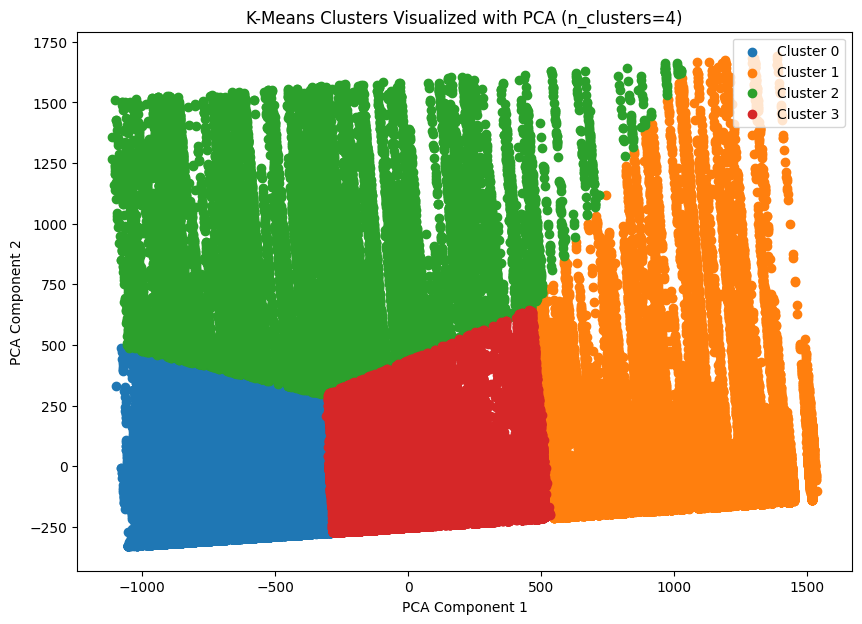

In [34]:
X_transformed, pca_model = run_pca(X_train_test_full, variance_threshold=0.95)


best_kmeans, best_labels = run_kmeans_with_evaluation(X_transformed, n_clusters=4)


plot_clusters_pca(X_transformed, best_labels, n_clusters=4)

In [35]:
# done